# Introduction
# Project Introduction

The dataset comes from Kaggle, it contains user preference from 73516 users on 12294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.

This data has 7 variables:

-`anime_id` : myanimelist.net's unique id identifying an anime.

-`name` : full name of anime.

-`genre` : comma separated list of genres for this anime.

-`type` : movie, TV, OVA, etc.

-`episodes`: how many episodes in this show. (1 if movie).

-`rating` : average rating out of 10 for this anime.

-`members` : number of community members that are in this anime's
"group".

Will more people view the anime cause a lower rating? Will less episodes anime have a higher rating? In this project, we will explore what factors affecting the rating of the anime. How can we classify the anime into different groups? If a person like this anime, what other anime will they like? To solve this problem, we will build a recommendation system.

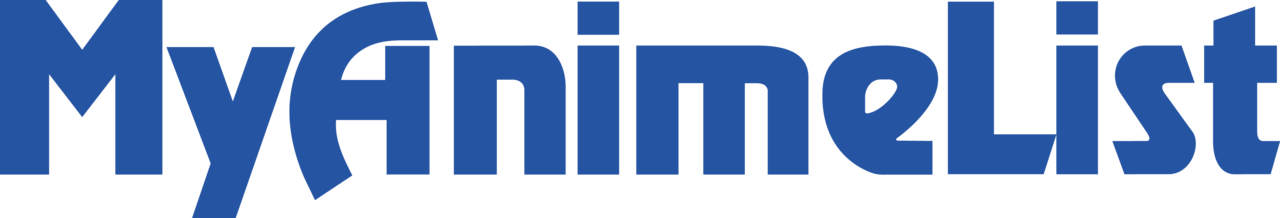

In [1]:
import pandas as pd
import io
import requests
def install_data():

  url='https://drive.google.com/uc?export=download&id=1Q8cGPWP-ATC4ingPzWkAQJw8y1VO1VcW'
  s=requests.get(url).content
  c=pd.read_csv(io.StringIO(s.decode('utf-8')))
  return c
df = install_data()
df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [2]:
%%html
<!-- this should be the ONLY html cell in the notebook: use markdown -->
<div style="font-size:36px; max-width:800px; font-family:Times, serif;">
 Anime Analysis
<video width="600" controls>
  <source src="https://drive.google.com/uc?export=download&id=1-jrAmObuKNofvOrWz6TvpWe3uuahELlH"
  type="video/mp4">
</video>
</div>

In [5]:
# import all libraries that I may need
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns

import warnings
import math
import scipy.stats as stats
import scipy
from sklearn.preprocessing import scale

# Data Acquisition, Selection, Cleaning
**Data Preparation**

1. Check for data types
   *   `episodes` should be numeric value, so change it into numeric value
2. Check for missing value
   *   Found missing value in `genre`, `type`, `episodes`, `rating`.
   *   Decide to drop the missing values
3. For the `genre` column, some anime belong to multiple genre. In order to have a better analysis result, I choose to use the first genre as their genre. 


In [6]:
df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

In [7]:
#change episodes into numeric value
df['episodes'] = df['episodes'].apply(pd.to_numeric, errors='coerce')

In [8]:
df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes    340
rating      230
members       0
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df['genre'] = df.genre.str.split().str.get(0)
li=[]
for i in df['genre']:
  li.append(str(i).replace(',',''))
df['genre'] = li
df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,Drama,Movie,1.0,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64.0,9.26,793665
2,28977,Gintama°,Action,TV,51.0,9.25,114262
3,9253,Steins;Gate,Sci-Fi,TV,24.0,9.17,673572
4,9969,Gintama&#039;,Action,TV,51.0,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1.0,4.15,211
12290,5543,Under World,Hentai,OVA,1.0,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4.0,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1.0,4.98,175


**Analysis Techniques**
First, I am going to do a regression analysis to see will the episode and members will affect the rating. Then, I will also cluster the anime into different groups. Finally, I will build a recommendation systems. I will sort out the top animes in each genre, and I will also use tf.idf as a metric to build a recommendation function. 

# Data Exploration
There are four numeric colums, and anime_id is not very meaningful here in our analysis. After data cleaning, there are 11830 instances in our dataset, the average episodes in anime is 12.48, the average rating is 6.48, and the average members is 18511. 

In [11]:
df.describe()

,anime_id,episodes,rating,members
count,11830.000000,11830.000000,11830.000000,1.183000e+04
mean,13404.150211,12.486729,6.484609,1.851100e+04
std,11110.087616,47.097131,1.019147,5.537144e+04
min,1.000000,1.000000,1.670000,1.200000e+01
25%,3326.250000,1.000000,5.892500,2.322500e+02
50%,9820.500000,2.000000,6.570000,1.589500e+03
75%,23302.500000,12.000000,7.190000,9.832000e+03
max,34519.000000,1818.000000,10.000000,1.013917e+06


To better understand the data, I sort the data based on their rating. I find that the highest rating anime usually has less members. 

In [12]:
#highest rating anime
df.sort_values(by='rating', ascending=False).head()

,anime_id,name,genre,type,episodes,rating,members
10464,33662,Taka no Tsume 8: Yoshida-kun no X-Files,Comedy,Movie,1.0,10.00,13
9595,23005,Mogura no Motoro,Slice,Movie,1.0,9.50,62
0,32281,Kimi no Na wa.,Drama,Movie,1.0,9.37,200630
9078,33607,Kahei no Umi,Historical,Movie,1.0,9.33,44
1,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64.0,9.26,793665


Then, I sort the data based on the number of members, and find that the rating is relatively not that high. From here, I suspect that the rating of the anime is maybe determined by the number of members.

In [13]:
df.sort_values(by='members', ascending=False).head()

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,Mystery,TV,37.0,8.71,1013917
86,16498,Shingeki no Kyojin,Action,TV,25.0,8.54,896229
804,11757,Sword Art Online,Action,TV,25.0,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64.0,9.26,793665
159,6547,Angel Beats!,Action,TV,13.0,8.39,717796


I also checked the mean rating of each genre and find that the highest average rating anime is Josei, Mystery, Drama, Action, and Police.

In [14]:
s = df['rating'].groupby(df['genre']).mean()
s.sort_values(ascending=False).head()

genre
Josei      7.366667
Mystery    7.081143
Drama      6.797379
Action     6.787802
Game       6.747429
Name: rating, dtype: float64

I checked the number of anime in each genre, and I find that most anime are Comedy, and following by Action, Adventure, Drama, and Hentai.

<BarContainer object of 5 artists>

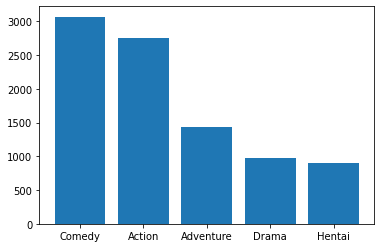

In [15]:
df['genre'].dropna
ct = df['genre'].value_counts()
cts = ct[0:5].to_dict()
gen = list(cts.keys()) 
val = list(cts.values()) 
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(gen,val)


In the end of my exploratory data analysis, I check the correlation between each variable, and find that the rating has a positive correlation with members. other variables hava a relativly weak correaltion with each other.

<AxesSubplot:>

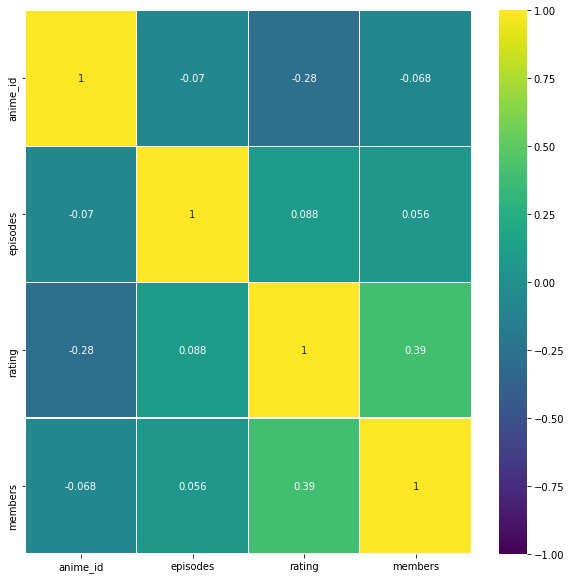

In [16]:
df_kor = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_kor, vmin=-1, vmax=1, cmap="viridis", annot=True, linewidth=0.1)

# Data Analysis
First, I am doing a regression analysis to check if the rating affected by members and episodes. I firstly drop all the missing values since we have a large dataset. Then I did a regression analysis, the R square is 0.158, which is low. All the parameters are significant. After visualizing our model accuracy, we can tell that our model is not that accurate. As a result, the rating is not mainly affected by the episodes and the amount of members.

In [17]:
X = df[['episodes','members']]
Y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)#split data into test and train
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     890.9
Date:                Mon, 08 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:41:06   Log-Likelihood:                -12813.
No. Observations:                9464   AIC:                         2.563e+04
Df Residuals:                    9461   BIC:                         2.565e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3363      0.010    608.070      0.000       6.316       6.357
episodes       0.0012      0.000      6.434      0.000       0.001       0.002
members      7.24e-06   1.75e-07     41.311      0.000     6.9e-06    7.58e-06
==============================================================================
Omnibus:                      842.384   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1163.722
Skew:                          -0.730   Prob(JB):                    2.00e-253
Kurtosis:                       3.904   Cond. No.                     6.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

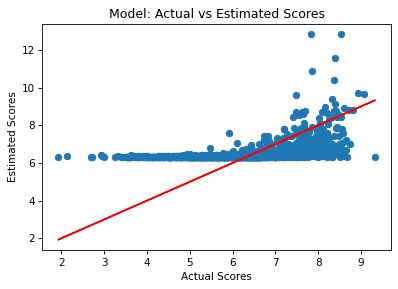

In [18]:
X_test = sm.add_constant(X_test)
y_preds = results.predict(X_test)
plt.figure(dpi = 75)
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Actual Scores")
plt.ylabel("Estimated Scores")
plt.title("Model: Actual vs Estimated Scores")
plt.show()

In the end, I am going to build a recommendation system that based on the similarity between anime based on genre and type. Then I will suggests anime that are most similar to a particular anime that a user will like. I will be using the cosine similarity to denote how close the two anime are. After having a pairwise cosine similarity matrix for all the anime in our dataset. The next step in our function will return the 30 most similar anime based on the cosine similarity score.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet




tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
df['description'] = df['genre'] + df['type']
df['description'] = df['description'].fillna('')
tfidf_matrix = tf.fit_transform(df['description'].dropna())
tfidf_matrix.shape
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
df = df.reset_index()
titles = df['name']
indices = pd.Series(df.index, index=df['name'])
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    anime_indices = [i[0] for i in sim_scores]
    return titles.iloc[anime_indices]

get_recommendations('Gintama').head(10)

2                               Gintama°
4                          Gintama&#039;
6                 Hunter x Hunter (2011)
9               Gintama&#039;: Enchousen
12                               Gintama
13    Code Geass: Hangyaku no Lelouch R2
19       Code Geass: Hangyaku no Lelouch
22                          Cowboy Bebop
23                         One Punch Man
29            Tengen Toppa Gurren Lagann
Name: name, dtype: object

From the result, we can see that it returns most of the Gintama movies. The rest of the anime that it recommends does pretty similiar to Gintama. However, the rating of Hunter x Hunter is pretty high, and it only shows at the third place. 

For the previous model, we did not consider the rating and members. The previous one will just return any similiar genre and type of anime regarless if it is a good anime. Therefore, I decide to add weighted rating to remove those low rating anime. I will take the top 25 anime based on similarity scores and calculate the members of the 90th percentile anime. Then, using this as the value of  m , we will calculate the weighted rating of each anime using IMDB's formula. I get the IMDB calculation method online, it is a way to calculate the weight rating.
Mathematically, it is represented as follows:

Weighted Rating (WR) =  $(\frac{v}{v+m}.R)+(\frac{m}{v+m}.C)$ 
where,

*   v is the number of members for the anime
*   m is the minimum members required to be listed 
*   R is the average rating of the anime
*   C is the mean rating across the whole report

In [22]:
members = df[df['members'].notnull()]['members'].astype('int')
m = members.quantile(0.90)
rating = df[df['rating'].notnull()]['rating'].astype('float')
C = rating.mean()
def weighted_rating(x):
    v = x['members']
    R = x['rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    anime_indices = [i[0] for i in sim_scores]
    
    anime = df.iloc[anime_indices][['name', 'rating', 'members']]
    rating = anime[anime['rating'].notnull()]['rating'].astype('float')
    members = anime[anime['members'].notnull()]['members'].astype('int')
    C = rating.mean()
    m = members.quantile(0.60)
    qualified = anime[(anime['members'] >= m) & (anime['members'].notnull()) & (anime['rating'].notnull())]
    qualified['rating'] = qualified['rating'].astype('float')
    qualified['members'] = qualified['members'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

improved_recommendations('Gintama').head(10)

<ipython-input-22-c5c8c6a7edda>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['rating'] = qualified['rating'].astype('float')
<ipython-input-22-c5c8c6a7edda>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['members'] = qualified['members'].astype('int')
<ipython-input-22-c5c8c6a7edda>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

,name,rating,members,wr
6,Hunter x Hunter (2011),9.13,425855,8.868151
13,Code Geass: Hangyaku no Lelouch R2,8.98,572888,8.791606
19,Code Geass: Hangyaku no Lelouch,8.83,715151,8.685992
23,One Punch Man,8.82,552458,8.637674
22,Cowboy Bebop,8.82,486824,8.615248
29,Tengen Toppa Gurren Lagann,8.78,562962,8.603884
85,Shingeki no Kyojin,8.54,896229,8.438031
67,Kiseijuu: Sei no Kakuritsu,8.59,425457,8.381426
97,Psycho-Pass,8.50,509109,8.330387
93,Fate/Zero,8.51,453630,8.320648


From the result, we do see a better recommendation system that will recommend people the anime by considering its rating and member base. As a result, the recommendation that my system give is also more reasonable.
# Conclusion
In a conclusion, the rating of an anime is not significantly affected by members and episodes. The anime can be divided into four groups based on the rating, episodes, and members attributes. The recommendation system that I built is pretty accurate. The later one with the weighted rating attribute does improve the recommendation system. For the future analysis, I want to include more detailed information in the dataset, like the directior and the voice actors of the anime to improve the precision of my recommendation. 